In [2]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
%matplotlib inline

def set_plot_defaults():

    multiplikator = 0.5

    plt.rcParams['axes.linewidth'] = 2 * multiplikator # set the value globally
    plt.rcParams['xtick.major.size'] = 5 * multiplikator
    plt.rcParams['xtick.major.width'] = 2 * multiplikator
    plt.rcParams['xtick.minor.size'] = 10 * multiplikator
    plt.rcParams['xtick.minor.width'] = 2 * multiplikator
    plt.rcParams['ytick.major.size'] = 5 * multiplikator
    plt.rcParams['ytick.major.width'] = 2 * multiplikator
    plt.rcParams['ytick.minor.size'] = 10 * multiplikator
    plt.rcParams['ytick.minor.width'] = 2 * multiplikator

    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['figure.dpi'] = 300 
    plt.gcf().subplots_adjust(wspace=0, hspace=0.3)

    font_size = 18

    params = {'axes.labelsize': font_size,
              'axes.titlesize': font_size,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size}

    plt.rcParams.update(params)
    sns.set_style('ticks')
    
set_plot_defaults()

<Figure size 3600x2400 with 0 Axes>

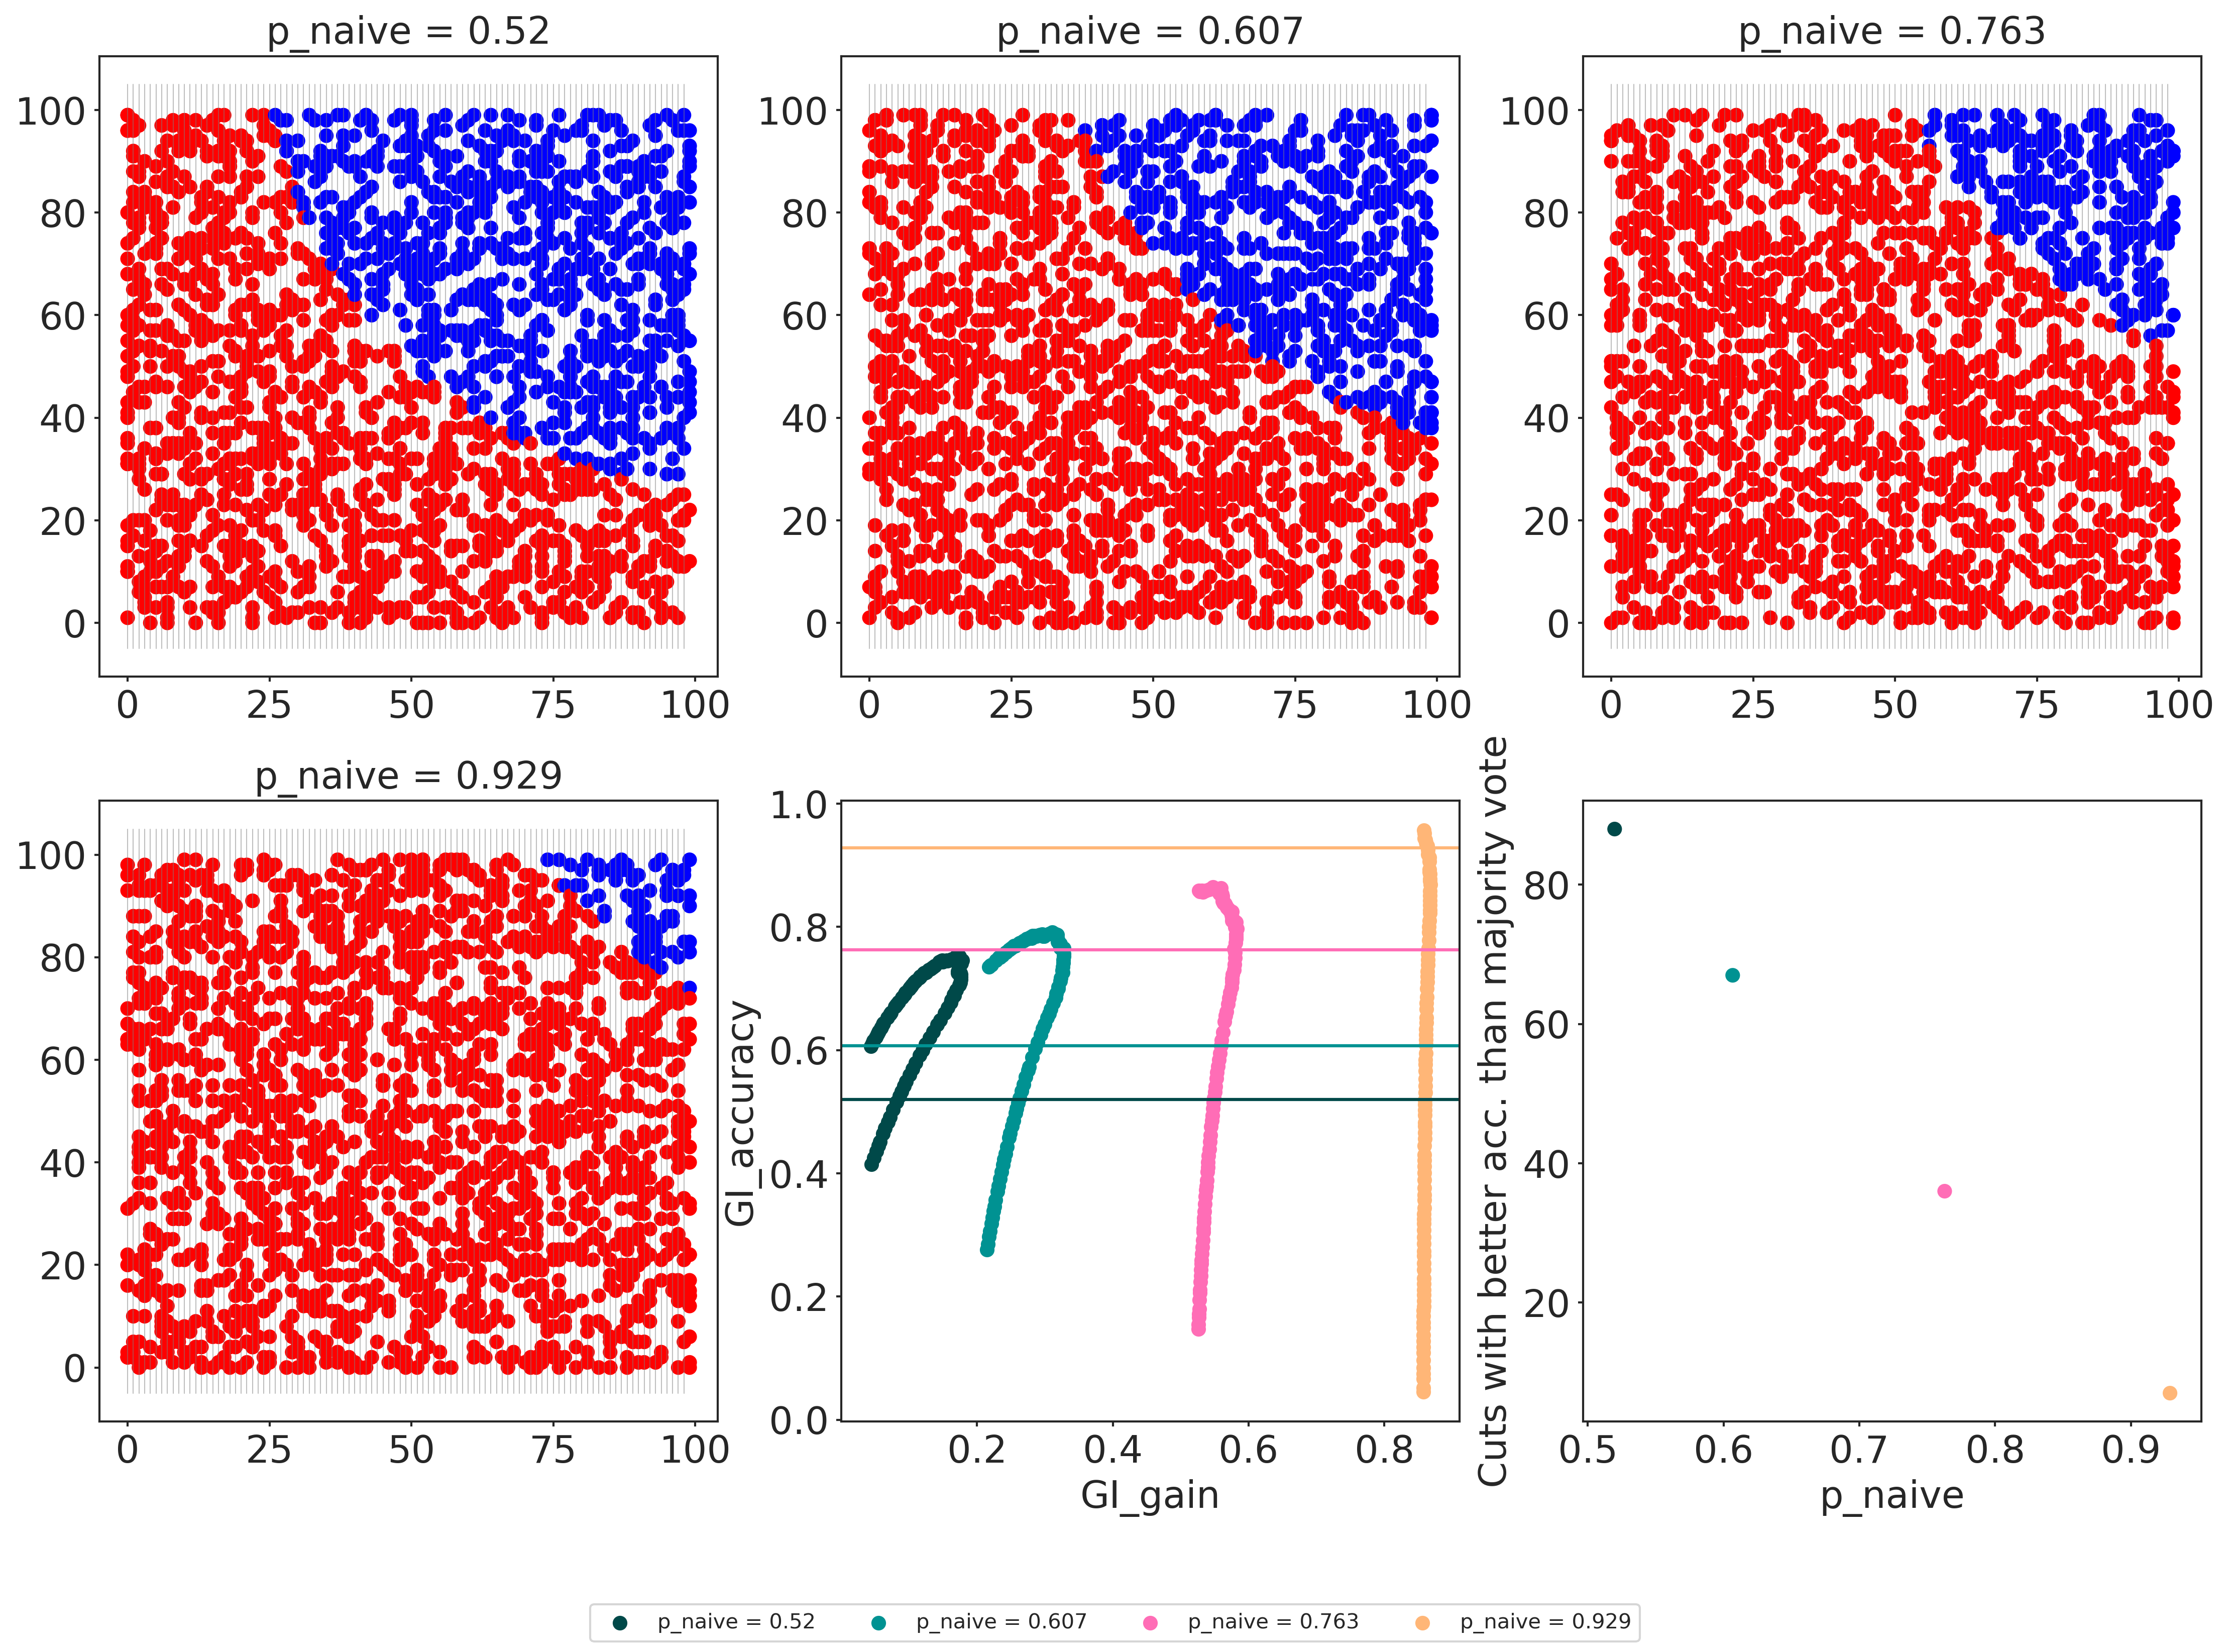

In [12]:
n_points = 2000
n_cuts = 100
js = [50, 60, 72, 85]
somsault_1_rgba = (  0,   0,   0, 255)
somsault_2_rgba = (  0/255,  73/255,  73/255, 255/255)
somsault_3_rgba = (  0/255, 146/255, 146/255, 255/255)
somsault_4_rgba = (255/255, 109/255, 182/255, 255/255)
somsault_5_rgba = (255/255, 182/255, 119/255, 255/255)
colors = [somsault_2_rgba, somsault_3_rgba, somsault_4_rgba, somsault_5_rgba]

n_y = 2 # rows
n_x = 3 # columns

panel_pos = [[0,0], [0,1], [0,2],
             [1,0], [1,1], [1,2]] 

fig, axs = plt.subplots(n_y, n_x)
fig.set_size_inches(18, 12)

js_dependency = pd.DataFrame()

for l in range(0, len(js)):

    p_x = sorted([random.randint(0, 99) for p in range(0, n_points)])
    p_y = [random.randint(0, 99) for p in range(0, n_points)]

    data = pd.DataFrame({"p_x": p_x,
                         "p_y": p_y})

    classes = np.sqrt((data.p_x*data.p_y))
    data["truth"] = ["blue" if x > js[l] else "red" for x in classes]

    pos_counter = l
    pos_x = panel_pos[pos_counter][0]
    pos_y = panel_pos[pos_counter][1]
    axs[pos_x, pos_y].scatter(x=data.p_x, 
                              y=data.p_y, 
                              c=data.truth,
                              alpha=1)

    # randomly draw lines for splits
    # x_coords = sorted([random.randint(0, 99) for p in range(0, n_cuts)])
    x_coords = range(0, n_cuts, 1)

    for x_coord in x_coords:

        axs[pos_x, pos_y].plot([x_coord, x_coord], 
                               [-5, 105], 
                               color="grey", 
                               linestyle='-', 
                               linewidth=0.5,
                               alpha=0.5)

        correct = ["blue" if x > x_coord else "red" for x in p_x]
        data = pd.concat([data, pd.DataFrame({"x@"+str(x_coord):correct})], axis=1)

    cuts = pd.DataFrame()    

    for c in data.columns:

        if "@" in c:

            x_cutoff = int(c[2:])

            ########################################################################
            # Count left side of split

            left = data[data.p_x <= x_cutoff]
            left_counts = {"red": 0, "blue": 0}

            tmp = left["truth"].value_counts().to_dict()

            for k in tmp:

                left_counts[k] = tmp[k]

            n_red = left_counts["red"]
            n_blue = left_counts["blue"]

            if (n_red > 0 and n_blue > 0):

                n_red_p = (n_red / (n_red + n_blue))
                n_blue_p = (n_blue / (n_red + n_blue))
                gi_left = (n_red_p * (1-n_red_p)) + (n_blue_p * (1-n_blue_p)) 

            else:

                gi_left = 0

            n_left = n_red + n_blue

            ########################################################################
            # Count right side of split

            right = data[data.p_x > x_cutoff]
            right_counts = {"red": 0, "blue": 0}

            tmp = right["truth"].value_counts().to_dict()

            for k in tmp:

                right_counts[k] = tmp[k]

            n_red = right_counts["red"]
            n_blue = right_counts["blue"]

            if (n_red > 0 and n_blue > 0):

                n_red_p = (n_red / (n_red + n_blue))
                n_blue_p = (n_blue / (n_red + n_blue))
                gi_right = (n_red_p * (1-n_red_p)) + (n_blue_p * (1-n_blue_p)) 

            else:

                gi_right = 0

            n_right = n_red + n_blue

            ########################################################################
            # Calculate true positives for accuracy

            counts = {"True": 0, "False": 0}

            tmp = (data.truth == data[c]).value_counts().to_dict()

            for k in tmp:

                counts[str(k)] = tmp[k]

            acc = counts["True"] / n_points

            ########################################################################
            # Add split to result df

            cuts = pd.concat([cuts, pd.DataFrame({"x": [x_cutoff], 
                                                  "n_left": [n_left],
                                                  "GI_left": [gi_left], 
                                                  "n_right": [n_right],
                                                  "acc": [acc],
                                                  "GI_right": [gi_right]})])

    ################################################################################
    # Calculate naive probability

    p_naive = sum((data.truth.value_counts()/n_points)**2)
    axs[pos_x, pos_y].set_title("p_naive = " + str(np.round(p_naive, 3)))
    
    ################################################################################
    # Calculate weighted Gini Impurity

    GI_w = []
    GI_gainz = []
    GI_accuracies = []

    for _, cut in cuts.iterrows():

        GI_weighted = (cut.n_left/(cut.n_left + cut.n_right)) * cut.GI_left + \
                      (cut.n_right/(cut.n_left + cut.n_right)) * cut.GI_right

        GI_w.append(GI_weighted)
        GI_gainz.append(p_naive-GI_weighted)

    cuts["GI_weighted"] = GI_w
    cuts["GI_gain"] = GI_gainz

#     print(cuts.sort_values("GI_gain").tail(3))

    axs[1, 1].scatter(cuts.GI_gain, 
                      cuts.acc, 
                      color=colors[l], 
                      label="p_naive = " + str(np.round(p_naive, 3)))
    axs[1, 1].set_xlabel("GI_gain")
    axs[1, 1].set_ylabel("GI_accuracy")
    axs[1, 1].axhline(y=p_naive, 
                color=colors[l], 
                linestyle="-")
    
    n_above = len(cuts.loc[cuts.acc > p_naive].acc)
    
    js_dependency = pd.concat([js_dependency, pd.DataFrame({"p_naive": [p_naive],
                                                            "n_above": [n_above]})])
    
    
    
axs[1, 2].scatter(js_dependency.p_naive, js_dependency.n_above, color=colors)
axs[1, 2].set_xlabel("p_naive")
axs[1, 2].set_ylabel("Cuts with better acc. than majority vote")
    
handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4)


plt.savefig("/shared_data/google-drive/Projekte/stackoverflow_answers/gini-impurity-in-decision-tree-reasons-to-use-it.png")  

In [112]:
n_points = 10000
n_cuts = 99
# js = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
js = range(0, 100, 5)
somsault_1_rgba = (  0,   0,   0, 255)
somsault_2_rgba = (  0/255,  73/255,  73/255, 255/255)
somsault_3_rgba = (  0/255, 146/255, 146/255, 255/255)
somsault_4_rgba = (255/255, 109/255, 182/255, 255/255)
somsault_5_rgba = (255/255, 182/255, 119/255, 255/255)
colors = [somsault_2_rgba, somsault_3_rgba, somsault_4_rgba, somsault_5_rgba]

generate_plot = False

n_y = 2 # rows
n_x = 10 # columns

panel_pos = [[0,0], [0,1], [0,2], [0,3], [0,4], [0,5], [0,6], [0,7], [0,8], [0,9],
             [1,0], [1,1], [1,2], [1,3], [1,4], [1,5], [1,6], [1,7], [1,8], [1,9]] 

if generate_plot:

    fig, axs = plt.subplots(n_y, n_x)
    fig.set_size_inches(50, 8)

metrics = pd.DataFrame()

for l in range(0, len(js)):

    p_x = sorted([random.randint(0, 99) for p in range(0, n_points)])
    p_y = [random.randint(0, 99) for p in range(0, n_points)]

    data = pd.DataFrame({"p_x": p_x,
                         "p_y": p_y})

    classes = np.sqrt((data.p_x*data.p_y))
    data["truth"] = ["blue" if x > js[l] else "red" for x in classes]

    if generate_plot:
    
        pos_counter = l
        pos_x = panel_pos[pos_counter][0]
        pos_y = panel_pos[pos_counter][1]
        axs[pos_x, pos_y].scatter(x=data.p_x, 
                                  y=data.p_y, 
                                  c=data.truth,
                                  alpha=1)

    # randomly draw lines for splits
    # x_coords = sorted([random.randint(0, 99) for p in range(0, n_cuts)])
    x_coords = range(0, n_cuts, 2)

    for x_coord in x_coords:

        if generate_plot:
        
            axs[pos_x, pos_y].plot([x_coord, x_coord], 
                                   [-5, 105], 
                                   color="grey", 
                                   linestyle='-', 
                                   linewidth=0.5,
                                   alpha=0.5)

        correct = ["blue" if x > x_coord else "red" for x in p_x]
        data = pd.concat([data, pd.DataFrame({"x@"+str(x_coord):correct})], axis=1)

    cuts = pd.DataFrame()    

    for c in data.columns:

        if "@" in c:

            x_cutoff = int(c[2:])

            ########################################################################
            # Count left side of split

            left = data[data.p_x <= x_cutoff]
            left_counts = {"red": 0, "blue": 0}

            tmp = left["truth"].value_counts().to_dict()

            for k in tmp:

                left_counts[k] = tmp[k]

            n_red = left_counts["red"]
            n_blue = left_counts["blue"]

            if (n_red > 0 and n_blue > 0):

                n_red_p = (n_red / (n_red + n_blue))
                n_blue_p = (n_blue / (n_red + n_blue))
                gi_left = (n_red_p * (1-n_red_p)) + (n_blue_p * (1-n_blue_p)) 

            else:

                gi_left = 0

            n_left = n_red + n_blue
            
            counts = {"True": 0, "False": 0}

            tmp = (left.truth == left[c]).value_counts().to_dict()

            for k in tmp:

                counts[str(k)] = tmp[k]

            gregwar_acc_left = counts["True"] / n_left

            ########################################################################
            # Count right side of split

            right = data[data.p_x > x_cutoff]
            right_counts = {"red": 0, "blue": 0}

            tmp = right["truth"].value_counts().to_dict()

            for k in tmp:

                right_counts[k] = tmp[k]

            n_red = right_counts["red"]
            n_blue = right_counts["blue"]

            if (n_red > 0 and n_blue > 0):

                n_red_p = (n_red / (n_red + n_blue))
                n_blue_p = (n_blue / (n_red + n_blue))
                gi_right = (n_red_p * (1-n_red_p)) + (n_blue_p * (1-n_blue_p)) 

            else:

                gi_right = 0

            n_right = n_red + n_blue
            
            counts = {"True": 0, "False": 0}

            tmp = (right.truth == right[c]).value_counts().to_dict()

            for k in tmp:

                counts[str(k)] = tmp[k]

            gregwar_acc_right = counts["True"] / n_right

            ########################################################################
            # Calculate true positives for accuracy

            counts = {"True": 0, "False": 0}

            tmp = (data.truth == data[c]).value_counts().to_dict()

            for k in tmp:

                counts[str(k)] = tmp[k]

            acc = counts["True"] / n_points

            ########################################################################
            # Add split to result df

            cuts = pd.concat([cuts, pd.DataFrame({"x": [x_cutoff], 
                                                  "n_left": [n_left],
                                                  "GI_left": [gi_left], 
                                                  "n_right": [n_right],
                                                  "acc": [acc],
                                                  "GI_right": [gi_right],
                                                  "gregwar_left": [gregwar_acc_left],
                                                  "gregwar_right": [gregwar_acc_right]})])

    ################################################################################
    # Calculate naive probability

    p_naive = sum((data.truth.value_counts()/n_points)**2)
    axs[pos_x, pos_y].set_title("p_naive = " + str(np.round(p_naive, 3)))
    
    ################################################################################
    # Calculate weighted Gini Impurity

    GI_w = []
    gregwr_w = []
    GI_gainz = []
    GI_accuracies = []

    for _, cut in cuts.iterrows():

        GI_weighted = (cut.n_left/(cut.n_left + cut.n_right)) * cut.GI_left + \
                      (cut.n_right/(cut.n_left + cut.n_right)) * cut.GI_right

        gregwar = (cut.n_left/(cut.n_left + cut.n_right)) * cut.gregwar_left + \
                  (cut.n_right/(cut.n_left + cut.n_right)) * cut.gregwar_right

        GI_w.append(GI_weighted)
        gregwr_w.append(gregwar)
        GI_gainz.append(p_naive-GI_weighted)

    cuts["GI_weighted"] = GI_w
    cuts["gregwar"] = gregwr_w
    cuts["GI_gain"] = GI_gainz

    if generate_plot:
    
        axs[1, pos_y].scatter(x=cuts.gregwar, 
                          y=cuts.GI_gain, 
    #                       color=colors[l], 
                          label="p_naive = " + str(np.round(p_naive, 3)))
        axs[1, pos_y].set_xlabel("gregwar")
        axs[1, pos_y].set_ylabel("GI_gain")
    #     axs[pos_x, pos_y].axhline(y=p_naive, 
    #                 color=colors[l], 
    #                 linestyle="-")

        n_above = len(cuts.loc[cuts.acc > p_naive].acc)
    
    ############################################################################
    # Count quality of split
    
    best_x_GI = cuts.sort_values("GI_gain").tail(1).x.to_list()[0]
#     best_x_GI = cuts.sort_values("GI_weighted").head(1).x.to_list()[0]
    best_x_gregwar = cuts.sort_values("gregwar").tail(1).x.to_list()[0]
    
    x_cutoffs = [best_x_GI, best_x_gregwar]
    types = ["GI", "gregwar"]
    
    for x_cutoff in range(0, len(x_cutoffs)):
    
        left = data[data.p_x <= x_cutoffs[x_cutoff]]
        left_counts = {"red": 0, "blue": 0}

        tmp = left["truth"].value_counts().to_dict()

        for k in tmp:

            left_counts[k] = tmp[k]

        n_red = left_counts["red"]
        n_blue = left_counts["blue"]
        n_left = n_red + n_blue
        
        counts = {"True": 0, "False": 0}

        tmp = (left.truth == left[c]).value_counts().to_dict()

        for k in tmp:

            counts[str(k)] = tmp[k]
            
        tp = counts["True"]
        fp = counts["False"]
        
        right = data[data.p_x > x_cutoffs[x_cutoff]]
        right_counts = {"red": 0, "blue": 0}
        
        tmp = right["truth"].value_counts().to_dict()

        for k in tmp:

            right_counts[k] = tmp[k]

        n_red = right_counts["red"]
        n_blue = right_counts["blue"]
        n_right = n_red + n_blue
        
        counts = {"True": 0, "False": 0}

        tmp = (right.truth == right[c]).value_counts().to_dict()

        for k in tmp:

            counts[str(k)] = tmp[k]
            
        tn = counts["True"]
        fn = counts["False"]
        
        metrics = pd.concat([metrics, pd.DataFrame({"seed" : [js[l]],
                                                    "type" : [types[x_cutoff]],
                                                    "cutoff": [x_cutoffs[x_cutoff]],
                                                    "tp": [tp],
                                                    "fp": [fp],
                                                    "tn": [tn],
                                                    "fn": [fn]})])
    
#     print(best_x_GI, best_x_gregwar)
    
    
metrics["precision"] = metrics.tp / (metrics.tp + metrics.fp)
metrics["recall"] = metrics.tp / (metrics.tp + metrics.fn)
metrics["f1"] = 2 * ((metrics.precision * metrics.recall)/(metrics.precision + metrics.recall))

print(metrics)
plt.savefig("/shared_data/google-drive/Projekte/stackoverflow_answers/gini-impurity-in-decision-tree-reasons-to-use-it_gregwar_1.png")  

   seed     type  cutoff    tp    fp    tn    fn  precision    recall  \
0     0       GI       0   105     0   190  9705   1.000000  0.010703   
0     0  gregwar       0   105     0   190  9705   1.000000  0.010703   
0     5       GI       0    93     0   264  9643   1.000000  0.009552   
0     5  gregwar       0    93     0   264  9643   1.000000  0.009552   
0    10       GI       2   280    52   534  9134   0.843373  0.029743   
0    10  gregwar       2   280    52   534  9134   0.843373  0.029743   
0    15       GI       4   440    69   830  8661   0.864440  0.048346   
0    15  gregwar       4   440    69   830  8661   0.864440  0.048346   
0    20       GI      10   863   253  1040  7844   0.773297  0.099116   
0    20  gregwar       8   758   147  1145  7950   0.837569  0.087046   
0    25       GI      14  1228   323  1329  7120   0.791747  0.147101   
0    25  gregwar      14  1228   323  1329  7120   0.791747  0.147101   
0    30       GI      16  1554   203  1785  6458   

<Figure size 3600x2400 with 0 Axes>

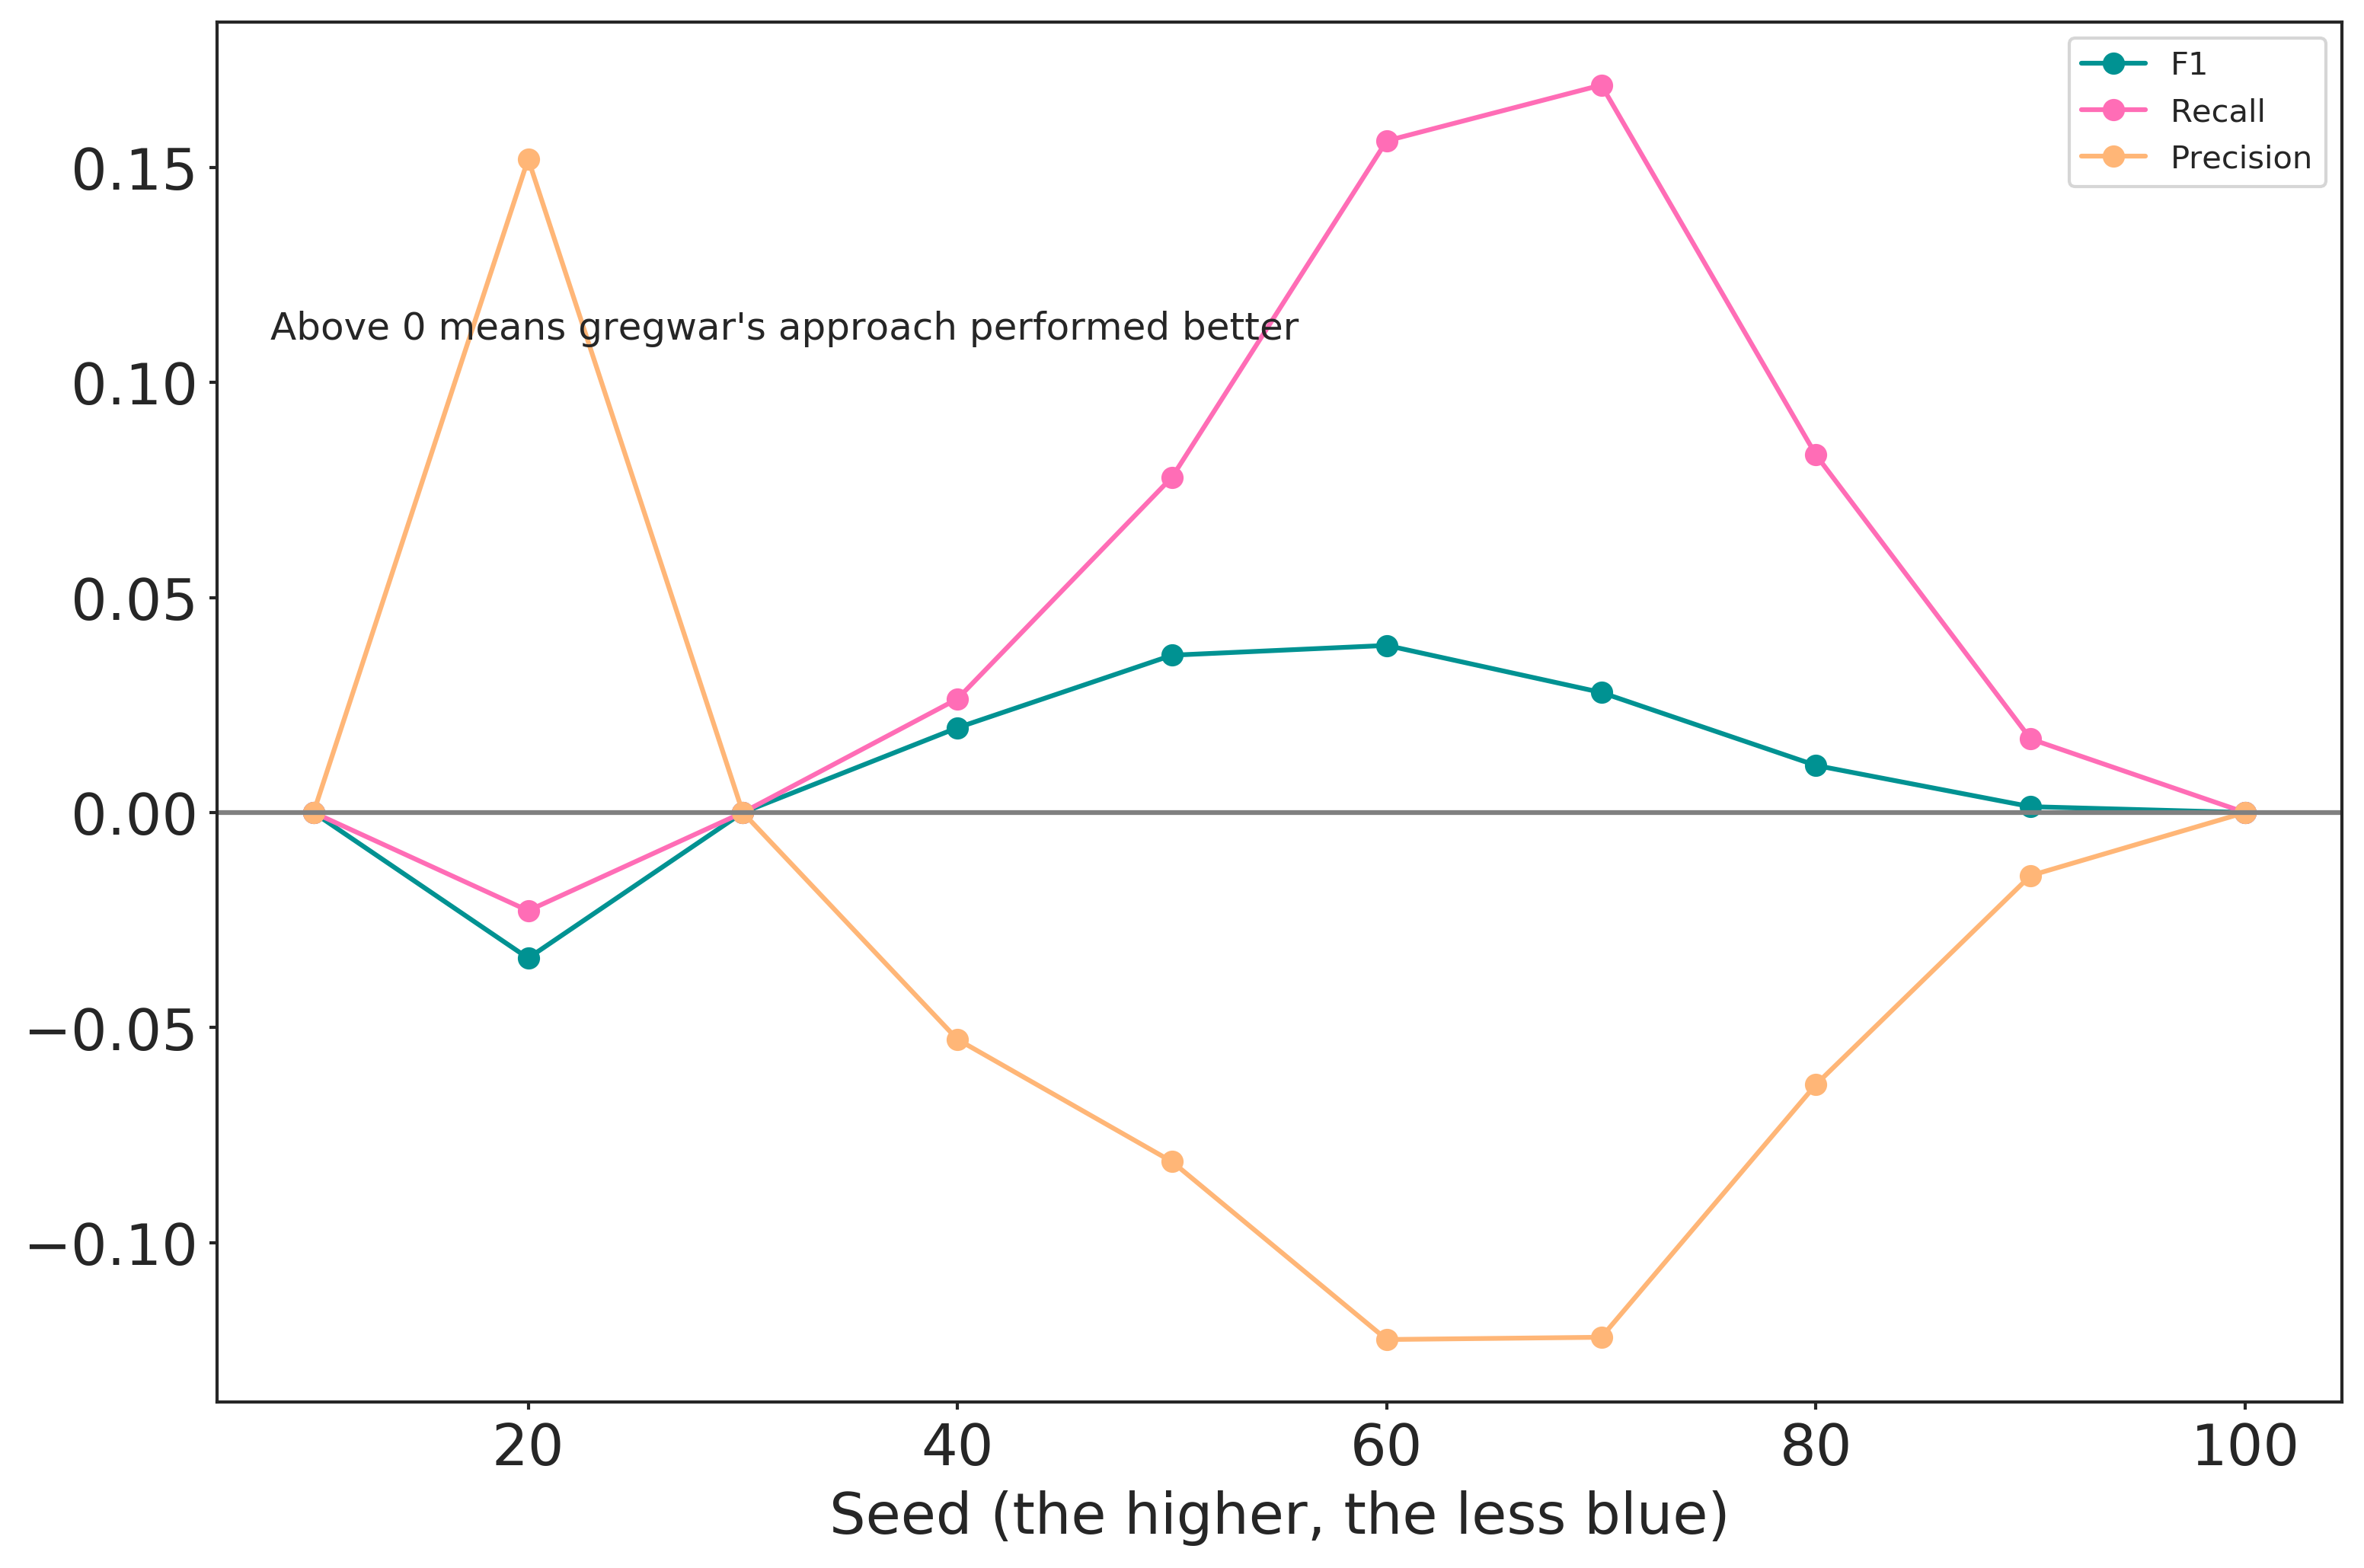

In [110]:
fig2, ax2 = plt.subplots(1, 1)
fig.set_size_inches(3, 3)
ax2.plot(metrics.loc[metrics.type == "GI"].seed,
        metrics.loc[metrics.type == "gregwar"].f1 - metrics.loc[metrics.type == "GI"].f1,
         "-o",
        color=somsault_3_rgba,
        label="F1")
ax2.plot(metrics.loc[metrics.type == "GI"].seed,
        metrics.loc[metrics.type == "gregwar"].recall - metrics.loc[metrics.type == "GI"].recall,
         "-o",
        color=somsault_4_rgba,
        label="Recall")
ax2.plot(metrics.loc[metrics.type == "GI"].seed,
        metrics.loc[metrics.type == "gregwar"].precision - metrics.loc[metrics.type == "GI"].precision,
         "-o",
        color=somsault_5_rgba,
        label="Precision")
ax2.axhline(y=0, 
            color="grey", 
            linestyle="-")

ax2.text(8, 0.11, "Above 0 means gregwar's approach performed better", fontsize=12)

ax2.set_xlabel("Seed (the higher, the less blue)")
ax2.legend()
plt.savefig("/shared_data/google-drive/Projekte/stackoverflow_answers/gini-impurity-in-decision-tree-reasons-to-use-it_gregwar_2.png")  